In [1]:
import numpy as np
from simulation.generate_path import generate_path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from estimation.distance_sensor import distance_sensors
from estimation.non_iterative_estimator import non_iterative_estimator
from estimation.kalman_filter_from_points_with_acc import kalman_filter_from_points_acc
import random
import torch
import torch.nn as nn
import time

/home/user/miniconda3/envs/cuda_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# create test data
target_initial_pos = np.array([0, 0, 5000])
target_speed_xy = 50
target_speed_z = 10
target_rot_speed = 3
time_res = 0.1

path1 = generate_path(0, target_speed_xy, target_speed_z, target_initial_pos, time_res)
path1.add_straight_interval(100)
path1.add_xy_turn_interval(90, -np.deg2rad(target_rot_speed))
path1.add_straight_interval(100)
outliers = np.random.randint(0, 100, size=len(path1.path))
outliers = outliers > (100 - 20)

# create noisy sensors
sensors = distance_sensors([[-5000,0,0],[ 400, -7400, 0],[ 800, 800, 0]], 15)
sensors.calculate_measurements(path1.path)
non_it_est = non_iterative_estimator(sensors, path1.path[0,:])
estimated_path = non_it_est.estimate_path()

sensors_noisy = distance_sensors([[-5000,0,0],[ 400, -7400, 0],[ 800, 800, 0]], 200)
sensors_noisy.calculate_measurements(path1.path)
non_it_est_noisy = non_iterative_estimator(sensors, path1.path[0,:])
estimated_path_noisy = non_it_est.estimate_path()

sigma_a = 1
sigma_v = 500
kf = kalman_filter_from_points_acc(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2)
kf_path, P, X = kf.filter_path(estimated_path)

sample = 1
XTest = []
for i in np.arange(len(kf_path) - sample):
    # tmp = np.concatenate((kf_path[i, :].reshape(1,-1), np.reshape(P[i, :, :], (1,-1)), X[i,:].reshape(1,-1)), 1)
    tmp = np.array([7000, 5000, 3000]).reshape(1,3)
    # if outliers[i+1]:
        # tmp =  np.concatenate((tmp, estimated_path_noisy[i+1, :].reshape(1,-1)),1)
        # tmp =  estimated_path_noisy[i+1, :].reshape(1,-1)
    # else:
        # tmp =  np.concatenate((tmp, estimated_path[i+1, :].reshape(1,-1)),1)
        # tmp =  estimated_path[i+1, :].reshape(1,-1)

    tmp = np.concatenate((tmp, outliers[i+1].reshape(1,1)), 1)

    # tmp = outliers[i+1].reshape(1,1)
    tmp = tmp.reshape(1, tmp.shape[1] ,1)
    if i > 0:
        XTest = np.concatenate((XTest, tmp), 2)
    else:
        XTest = tmp

YTest = outliers[1:].reshape(-1,1)

print(np.shape(YTest))
print(np.shape(XTest))

(2897, 1)
(1, 4, 2897)


In [3]:
# create train data
run_number = 50
for k in np.arange(run_number):
    target_initial_pos = np.random.randint(-7000, 7000, size=(1, 3))[0]
    sensors_pos = np.random.randint(-7000, 7000, size=(3, 3))[:,:]
    target_speed_xy = 50
    target_speed_z = 10
    target_rot_speed = 3
    time_res = 0.1

    path1 = generate_path(0, target_speed_xy, target_speed_z, target_initial_pos, time_res)
    path1.add_straight_interval(np.random.randint(0,100,size=1)[0])
    path1.add_xy_turn_interval(np.random.randint(0,100,size=1)[0], -random.choice([-1, 1])*np.deg2rad(target_rot_speed))
    outliers = np.random.randint(0, 100, size=len(path1.path))
    outliers = outliers > (100 - 20)

    # create noisy sensors
    sensors = distance_sensors(sensors_pos, 15)
    sensors.calculate_measurements(path1.path)
    non_it_est = non_iterative_estimator(sensors, path1.path[0,:])
    estimated_path = non_it_est.estimate_path()

    sensors_noisy = distance_sensors(sensors_pos, 200)
    sensors_noisy.calculate_measurements(path1.path)
    non_it_est_noisy = non_iterative_estimator(sensors, path1.path[0,:])
    estimated_path_noisy = non_it_est.estimate_path()

    sigma_a = 1
    sigma_v = 500
    kf = kalman_filter_from_points_acc(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2)
    kf_path, P, X = kf.filter_path(estimated_path)

    sample = 1
    XTrain = []
    for i in np.arange(len(kf_path) - sample):
        # tmp = np.concatenate((kf_path[i, :].reshape(1,-1), np.reshape(P[i, :, :], (1,-1)), X[i,:].reshape(1,-1)), 1)
        tmp = np.array([-50, -800, -5000]).reshape(1,3)
        # if outliers[i+1]:
            # tmp =  np.concatenate((tmp, estimated_path_noisy[i+1, :].reshape(1,-1)),1)
            # tmp =  estimated_path_noisy[i+1, :].reshape(1,-1)
        # else:
            # tmp =  np.concatenate((tmp, estimated_path[i+1, :].reshape(1,-1)),1)
            # tmp =  estimated_path[i+1, :].reshape(1,-1)

        tmp = np.concatenate((tmp, outliers[i+1].reshape(1,1)), 1)

        # tmp = outliers[i+1].reshape(1,1)
        tmp = tmp.reshape(1, tmp.shape[1] ,1)
        if i > 0:
            XTrain = np.concatenate((XTrain, tmp), 2)
        else:
            XTrain = tmp

    YTrain = outliers[1:].reshape(-1,1)

print(np.shape(YTrain))
print(np.shape(XTrain))


(538, 1)
(1, 4, 538)


In [4]:
# shuffle data
ind = np.arange(len(YTrain))
random.shuffle(ind)

XVal = torch.from_numpy(np.transpose(XTest[:,:,ind], (2, 0, 1)))
YVal = torch.from_numpy(YTest[ind,:])

XTrain = torch.from_numpy(np.transpose(XTrain[:,:,ind], (2, 0, 1)))
YTrain = torch.from_numpy(YTrain[ind,:])

In [5]:
# create network
class state_estimat(nn.Module):
    def __init__(self, d_in, num_classes):
        # initialzing the parent object (important!)
        super(state_estimat, self).__init__()
        # Create a pipeline - a sequence of layers
        self.pipe = torch.nn.Sequential(
            # nn.Conv1d(1, 16, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.Conv1d(16, 32, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.Conv2d(64, 64, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.Conv2d(64, 64, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.Linear(97, 10),
            # nn.ReLU(),
            # nn.Linear(97, 2),
            # nn.ReLU(),
            nn.Linear(4, num_classes))
            # nn.Softmax())

    def forward(self, x):
        return self.pipe(x)


In [6]:
# hyper-parameters:
# num_epochs = 100
num_epochs = 60
# batch_size = 512
batch_size = 4
learning_rate = 0.001
learning_rate_drop_period = 10

# Device configuration, as before
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)
# create model
model = state_estimat(d_in=10, num_classes=1).to(device)
print(model)
# Loss and optimizer
# criterion = torch.nn.BCELoss()
criterion = torch.nn.MSELoss()
# criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=learning_rate_drop_period, gamma=0.1)

cuda:0
state_estimat(
  (pipe): Sequential(
    (0): Linear(in_features=4, out_features=1, bias=True)
  )
)


In [7]:
# Train the model
total_step = len(YTrain)
start_time = time.time()
model = model.float()

loss_train = []
loss_val = []
loss_tmp = 0
norm = 1
for i in range(len(YVal)):
        # each i is a batch of 128 samples
        x, y = XVal[i,:,:], YVal[i,:]

        x = x.unsqueeze(0).to(device)
        y = y.unsqueeze(0).to(device)

        # Forward pass val
        outputs = model(x.float())
        loss = criterion(norm*outputs, norm*y.float().reshape(1,1,1))
        # loss = criterion(nn.Sigmoid()(norm*outputs), norm*y.float().reshape(1,1,1))
        # loss1 = criterion(norm*outputs, norm*y.float().T)
        # loss2 = torch.mean(outputs**2 - y.float().T**2)
        # loss = loss1 + loss2
        
        loss_tmp += loss.item()
loss_val.append(loss_tmp/len(YVal))

for epoch in range(num_epochs):
    ind = np.arange(int(total_step/batch_size))
    random.shuffle(ind)
    for i,k in enumerate(ind):
        # each i is a batch of 128 samples
        x, y = XTrain[k*batch_size:(k+1)*batch_size,:,:], YTrain[k*batch_size:(k+1)*batch_size,:]
        # x, y = XVal[k*batch_size:(k+1)*batch_size,:,:], YVal[k*batch_size:(k+1)*batch_size,:]

        x = x.to(device)
        y = y.to(device)

        # Forward pass
        outputs = model(x.float())
        loss = criterion(norm*outputs, norm*y.float().reshape(batch_size,1,1))
        # loss = criterion(nn.Sigmoid()(norm*outputs), norm*y.float().reshape(batch_size,1,1))
        # loss1 = criterion(norm*outputs, norm*y.float().T)
        # loss2 = torch.mean(outputs**2 - y.float().T**2)
        # loss = loss1 + loss2
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train.append(loss.item())

        if (i + 1) % 5== 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Time: {:.4f} secs, learning rate: {:.4f}'
                    .format(epoch + 1, num_epochs, i + 1, int(total_step/batch_size), loss.item(), time.time() - start_time, optimizer.param_groups[0]['lr']))

    loss_tmp = 0
    result = []
    for i in range(len(YVal)):
        # each i is a batch of 128 samples
        x, y = XVal[i,:,:], YVal[i,:]

        x = x.unsqueeze(0).to(device)
        y = y.unsqueeze(0).to(device)

        # Forward pass val
        outputs = model(x.float())
        loss = criterion(norm*outputs, norm*y.float().reshape(1,1,1))
        # loss = criterion(nn.Sigmoid()(norm*outputs), norm*y.float().reshape(1,1,1))
        # loss1 = criterion(norm*outputs, norm*y.float().T)
        # loss2 = torch.mean(outputs**2 - y.float().T**2)
        # loss = loss1 + loss2
        
        loss_tmp += loss.item()
        result.append(outputs[0,0].item())
        # result.append(nn.Sigmoid()(outputs[0,0]).item())
    loss_val.append(loss_tmp/len(YVal))

    scheduler.step()

Epoch [1/60], Step [5/134], Loss: 2197957.0000, Time: 0.5214 secs, learning rate: 0.0010
Epoch [1/60], Step [10/134], Loss: 2112210.2500, Time: 0.5231 secs, learning rate: 0.0010
Epoch [1/60], Step [15/134], Loss: 2029300.5000, Time: 0.5241 secs, learning rate: 0.0010
Epoch [1/60], Step [20/134], Loss: 1946754.2500, Time: 0.5250 secs, learning rate: 0.0010
Epoch [1/60], Step [25/134], Loss: 1867242.5000, Time: 0.5260 secs, learning rate: 0.0010
Epoch [1/60], Step [30/134], Loss: 1790760.5000, Time: 0.5269 secs, learning rate: 0.0010
Epoch [1/60], Step [35/134], Loss: 1714950.7500, Time: 0.5279 secs, learning rate: 0.0010
Epoch [1/60], Step [40/134], Loss: 1641466.7500, Time: 0.5288 secs, learning rate: 0.0010
Epoch [1/60], Step [45/134], Loss: 1571046.5000, Time: 0.5297 secs, learning rate: 0.0010
Epoch [1/60], Step [50/134], Loss: 1502894.0000, Time: 0.5307 secs, learning rate: 0.0010
Epoch [1/60], Step [55/134], Loss: 1437688.5000, Time: 0.5316 secs, learning rate: 0.0010
Epoch [1/60

(0.0, 1.0)

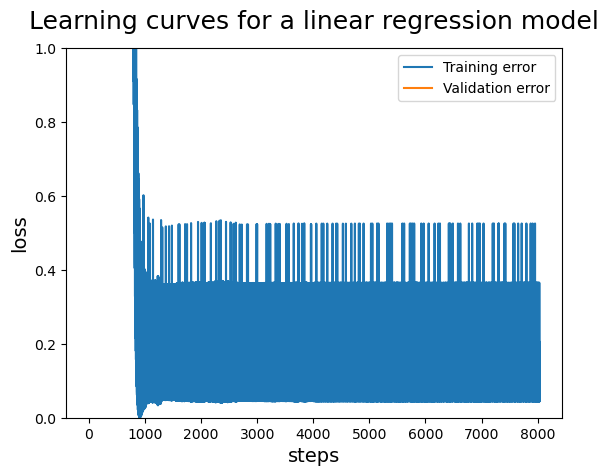

In [8]:
# plt.style.use('seaborn')
plt.plot(np.arange(len(loss_train)), loss_train, label = 'Training error')
plt.plot(np.arange(0, len(loss_train)+1, int(total_step/batch_size)), loss_val, label = 'Validation error')
plt.ylabel('loss', fontsize = 14)
plt.xlabel('steps', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim([0,1])

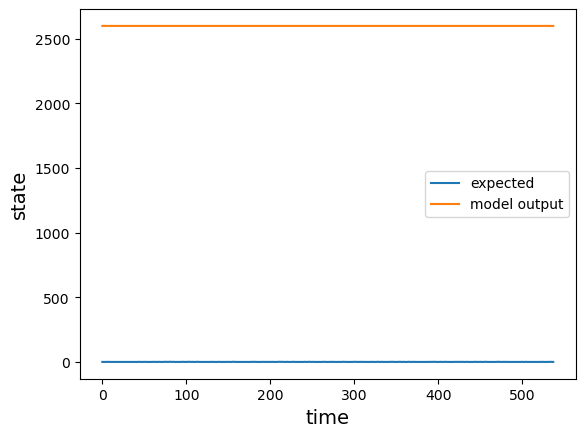

In [9]:
# plt.style.use('seaborn')
plt.plot(np.arange(len(result)), YVal, label = 'expected')
plt.plot(np.arange(len(result)), result, label = 'model output')
plt.ylabel('state', fontsize = 14)
plt.xlabel('time', fontsize = 14)
plt.legend()
# plt.ylim([-0.01,0.01])

In [10]:
print(len([i for i in YVal if i[0]]))
print(len([i for i in YVal if not i[0]]))

96
442
